## Import relevant libraries

In [114]:
from semopy import Model, calc_stats, semplot
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
import seaborn as sns
from semopy.inspector import inspect

#### Configure relative path

In [115]:
from pathlib import Path
import sys

# Step 1: find project root (where paths.py lives)
ROOT = Path.cwd().resolve()
while not (ROOT / "paths.py").exists():
    ROOT = ROOT.parent

# Step 2: make it importable
sys.path.insert(0, str(ROOT))

# Step 3: import paths
from paths import PROCESSED_DATA, OUTPUT_DIR, FIGURES_REPORTS

## Import the dataset

In [116]:
df = pd.read_csv(PROCESSED_DATA/"Welzijnsmonitor2025_scaled_normalised_UTF8.csv", sep=";")

In [117]:
Q1 = df['StPunt_beh'].quantile(0.25)
Q3 = df['StPunt_beh'].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (df['StPunt_beh'] < (Q1 - 1.5 * IQR)) | (df['StPunt_beh'] > (Q3 + 1.5 * IQR))
outlier_counts = outlier_mask.sum()

print("\nNumber of outliers per numeric variable:")
print(outlier_counts)

df = df[~outlier_mask].copy()
print("\nNew shape after removing outliers:", df.shape)


Number of outliers per numeric variable:
231

New shape after removing outliers: (1281, 76)


## Creating the model

In [118]:
model_desc = """
# measurement model

Wellbeing =~ Bevl_1 + Bevl_2 + Bevl_3 + Cogn_Eng1_5 + Mot_Stress_1 + Mot_Stress_4
Energy_Sources =~ Partici1_1 + Partici1_2 + Partici1_3
Negative_Outcomes =~ StopInt + Vertr
Positive_Outcomes =~ Cijfer_huidig_1 + StPunt_beh
Stressors =~ Onnodige_stress_2 + Onnodige_stress_3 + Onnodige_stress_4 + Onnodige_stress_5 + Onnodige_stress_6 + Onnodige_stress_8 + Onnodige_stress_9
Response_to_Stress =~ Burn1_1 + Burn1_2 + Depr_1 + Depr_2 + Depr_4 + Depr_6 + Depr_7 + Depr_8

# Covariances (two-headed arrows in the diagram)
Response_to_Stress ~~ Wellbeing
Stressors ~~ Energy_Sources
Negative_Outcomes ~~ Positive_Outcomes

# Regressions
Response_to_Stress ~ Stressors + Energy_Sources
Wellbeing ~ Stressors + Energy_Sources

Negative_Outcomes ~ Response_to_Stress + Wellbeing
Positive_Outcomes ~ Wellbeing + Response_to_Stress
"""

In [119]:
model = Model(model_desc)
model.fit(df)

df_imputed = model.predict(df)
latent_scores = model.predict_factors(df_imputed)

# Export the model with the new latent variables and their descriptive statistics

In [120]:
latent_scores.to_csv(OUTPUT_DIR/"latent_variable_scores.csv", index=False)
latent_scores.describe()

,Energy_Sources,Negative_Outcomes,Positive_Outcomes,Response_to_Stress,Stressors,Wellbeing
count,1.281000e+03,1.281000e+03,1.281000e+03,1.281000e+03,1.281000e+03,1.281000e+03
mean,-3.328069e-17,-8.320173e-17,3.466739e-17,-7.210816e-17,-6.656138e-17,1.969108e-16
std,6.380819e-01,1.795865e-01,2.585207e-01,5.402828e-01,7.026956e-01,5.292076e-01
min,-1.051294e+00,-3.722302e-01,-1.399395e+00,-1.131491e+00,-1.830762e+00,-1.936792e+00
25%,-5.057748e-01,-1.271188e-01,-1.065224e-01,-4.177108e-01,-5.122309e-01,-2.627629e-01
50%,-1.420699e-01,-2.932317e-02,4.064439e-02,-6.257639e-02,3.254507e-02,8.650138e-02
75%,4.264835e-01,9.194062e-02,1.573635e-01,3.712639e-01,5.218642e-01,3.455412e-01
max,1.884376e+00,7.196311e-01,5.694194e-01,1.845927e+00,1.620287e+00,1.230764e+00


In [121]:
latents = set(model.vars['latent'])
observeds = set(model.vars['observed'])

est = model.inspect(std_est=True)

# Factor loadings = observed ~ latent
loadings = est[
    (est['op'] == '~') &
    (est['lval'].isin(observeds)) &
    (est['rval'].isin(latents))
]

print("Factor loadings:")
display(loadings)

Factor loadings:


,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
8,Bevl_1,~,Wellbeing,1.000000,0.655807,-,-,-
9,Bevl_2,~,Wellbeing,1.141915,0.799843,0.046905,24.34551,0.0
10,Bevl_3,~,Wellbeing,1.111077,0.704389,0.050585,21.964545,0.0
11,Cogn_Eng1_5,~,Wellbeing,1.080270,0.643963,0.053076,20.353094,0.0
12,Mot_Stress_1,~,Wellbeing,1.175964,0.780983,0.049215,23.894387,0.0
13,Mot_Stress_4,~,Wellbeing,1.235074,0.860408,0.048087,25.684342,0.0
14,Partici1_1,~,Energy_Sources,1.000000,0.654448,-,-,-
15,Partici1_2,~,Energy_Sources,1.309761,0.761225,0.08065,16.239971,0.0
16,Partici1_3,~,Energy_Sources,0.993827,0.620494,0.061534,16.150941,0.0
17,StopInt,~,Negative_Outcomes,1.000000,0.504744,-,-,-


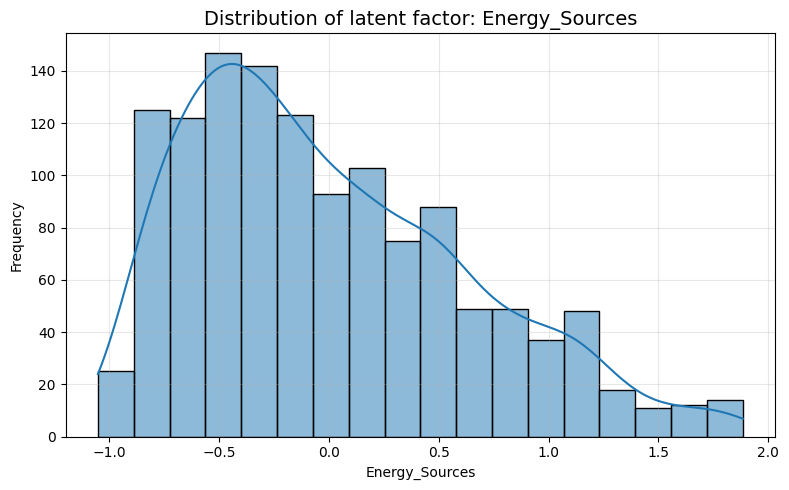

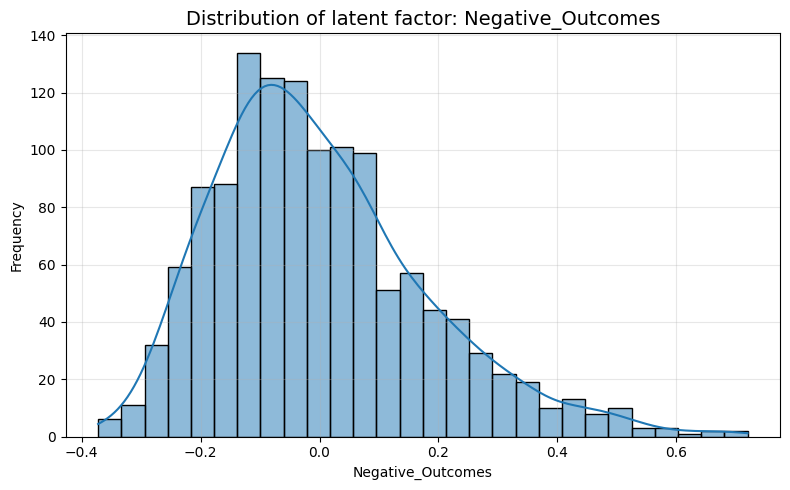

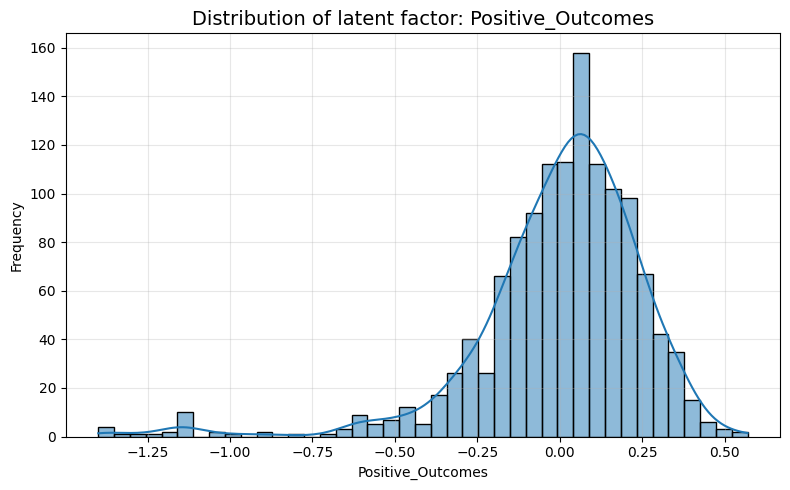

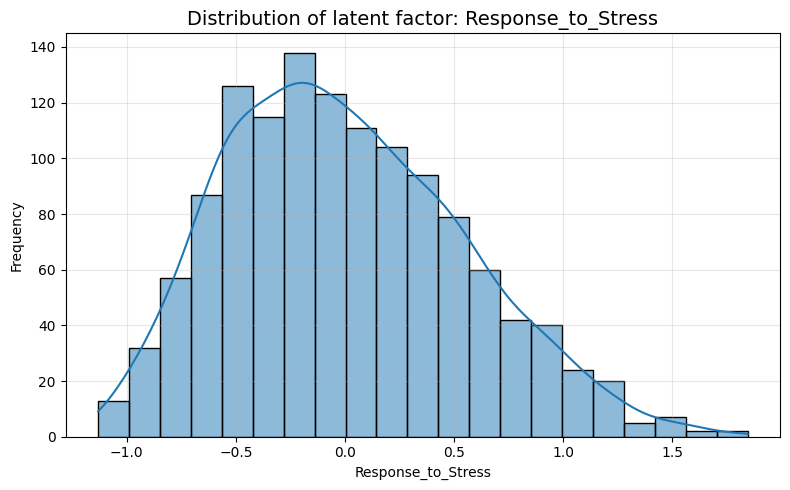

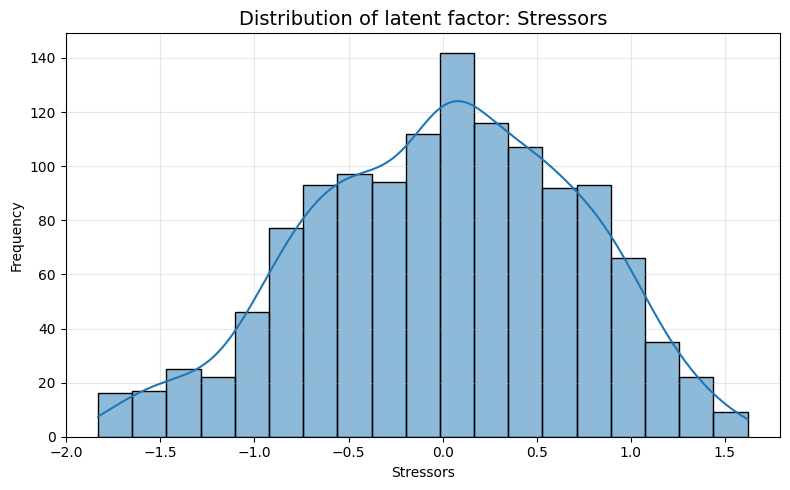

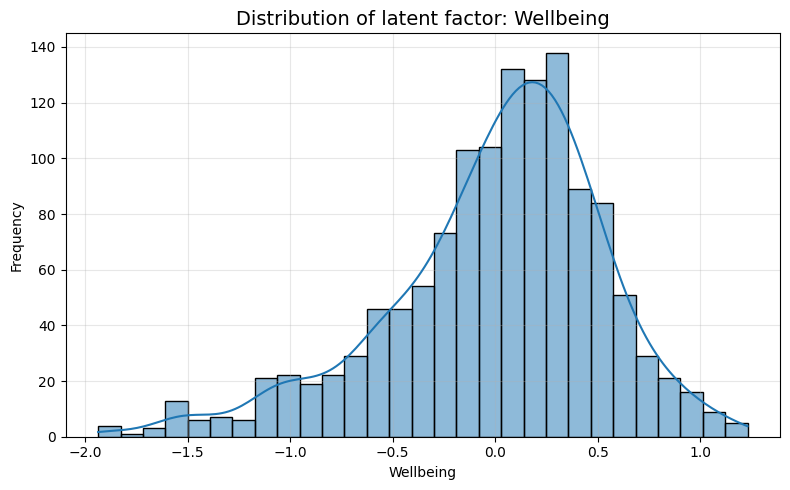

In [122]:
# Plot histogram for each latent variable
for col in latent_scores.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(latent_scores[col], kde=True)
    plt.title(f"Distribution of latent factor: {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Correlation matrix

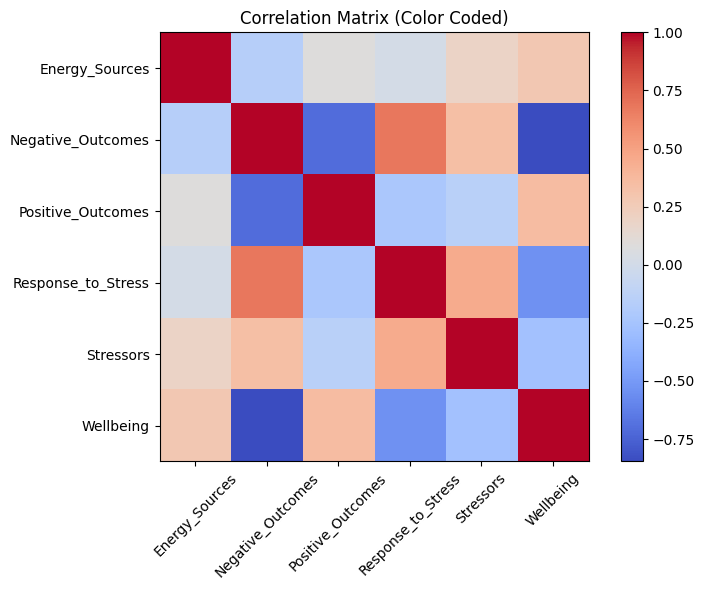

In [123]:
corr_matrix = latent_scores.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
plt.title("Correlation Matrix (Color Coded)")
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.tight_layout()
plt.show()

# print(corr_matrix)

### Calculate fit indices

In [124]:
stats = calc_stats(model)

print("=== Model Fit Statistics ===")
print(stats.T)

=== Model Fit Statistics ===
                      Value
DoF              339.000000
DoF Baseline     378.000000
chi2            1981.687569
chi2 p-value       0.000000
chi2 Baseline  13545.283543
CFI                0.875245
GFI                0.853699
AGFI               0.836868
NFI                0.853699
TLI                0.860892
RMSEA              0.061528
AIC              130.906030
BIC              476.317583
LogLik             1.546985


### Create and save the path diagram

In [125]:
plot_path = FIGURES_REPORTS / "pd3.png"
g = semplot(model, str(plot_path))

### Extract model coefficients

In [126]:
coefficients = model.inspect()
coefficients.to_csv(OUTPUT_DIR/"model_coefficients.csv")
coefficients.to_excel(OUTPUT_DIR/"model_coefficients.xlsx")

In [127]:
def pretty_sem_latent_explicit(model):
    df = model.inspect().copy()

    # List of latent relationships as (lval, op, rval)
    wanted = [
        # covariances
        ("Response_to_Stress", "~~", "Wellbeing"),
        ("Stressors", "~~", "Energy_Sources"),
        ("Negative_Outcomes", "~~", "Positive_Outcomes"),

        # regressions
        ("Response_to_Stress", "~",  "Stressors"),
        ("Response_to_Stress", "~",  "Energy_Sources"),
        ("Wellbeing",          "~",  "Stressors"),
        ("Wellbeing",          "~",  "Energy_Sources"),
        ("Negative_Outcomes",  "~",  "Response_to_Stress"),
        ("Negative_Outcomes",  "~",  "Wellbeing"),
        ("Positive_Outcomes",  "~",  "Response_to_Stress"),
        ("Positive_Outcomes",  "~",  "Wellbeing"),
    ]

    wanted_df = pd.DataFrame(wanted, columns=["lval", "op", "rval"])

    # Inner join to keep only those rows
    df = df.merge(wanted_df, on=["lval", "op", "rval"], how="inner")

    # Label type + from/to
    df["Type"] = df["op"].map({"~": "Regression", "~~": "Covariance"})
    df["From"] = df["lval"]
    df["To"]   = df["rval"]

    # Clean p-values (handles "<0.001")
    p_clean = df["p-value"].astype(str).str.replace("<", "", regex=False)
    df["p_value"] = pd.to_numeric(p_clean, errors="coerce")

    # Significance stars
    def stars(p):
        if pd.isna(p): return ""
        if p < 0.001: return "***"
        if p < 0.01:  return "**"
        if p < 0.05:  return "*"
        if p < 0.10:  return "."
        return ""

    df["Sig"] = df["p_value"].apply(stars)

    # Numeric & rounded
    for col in ["Estimate", "Std. Err", "z-value", "p_value"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").round(4)

    # Final table
    nice = df[[
        "Type", "From", "To",
        "Estimate", "Std. Err", "z-value", "p_value", "Sig"
    ]].copy()

    nice = nice.rename(columns={"Std. Err": "Std_Err"})

    return nice

latent_table = pretty_sem_latent_explicit(model)
latent_table   # last line in the cell → shows a nice table

,Type,From,To,Estimate,Std_Err,z-value,p_value,Sig
0,Regression,Response_to_Stress,Stressors,0.3096,0.0287,10.7833,0.0000,***
1,Regression,Response_to_Stress,Energy_Sources,-0.0336,0.0264,-1.2702,0.2040,
2,Regression,Wellbeing,Stressors,-0.1958,0.0249,-7.8759,0.0000,***
3,Regression,Wellbeing,Energy_Sources,0.2109,0.0275,7.6712,0.0000,***
4,Regression,Negative_Outcomes,Response_to_Stress,0.1048,0.0204,5.1315,0.0000,***
5,Regression,Negative_Outcomes,Wellbeing,-0.2233,0.0230,-9.7300,0.0000,***
6,Regression,Positive_Outcomes,Wellbeing,0.1468,0.0298,4.9243,0.0000,***
7,Regression,Positive_Outcomes,Response_to_Stress,-0.0249,0.0281,-0.8836,0.3769,
8,Covariance,Response_to_Stress,Wellbeing,-0.1243,0.0118,-10.5531,0.0000,***
9,Covariance,Stressors,Energy_Sources,0.0850,0.0202,4.1969,0.0000,***
